In [103]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.ensemble._forest import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
# from tensorflow.keras.model import sequential
from tensorflow.keras.layers import Dense,LSTM
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

In [104]:
store_sales=pd.read_csv('train1.csv')

In [105]:
store_sales.head(5)

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [106]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [107]:
store_sales=store_sales.drop(['store','item'],axis=1)

In [108]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   sales   913000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 13.9+ MB


In [109]:
store_sales['date']=pd.to_datetime(store_sales['date'])

In [110]:
store_sales.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   sales   913000 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 13.9 MB


In [111]:
store_sales['date']=store_sales['date'].dt.to_period("M")
monthly_sales=store_sales.groupby("date").sum().reset_index()

In [112]:
monthly_sales['date']=monthly_sales['date'].dt.to_timestamp()

In [113]:
monthly_sales.head(5)

,date,sales
0,2013-01-01,454904
1,2013-02-01,459417
2,2013-03-01,617382
3,2013-04-01,682274
4,2013-05-01,763242


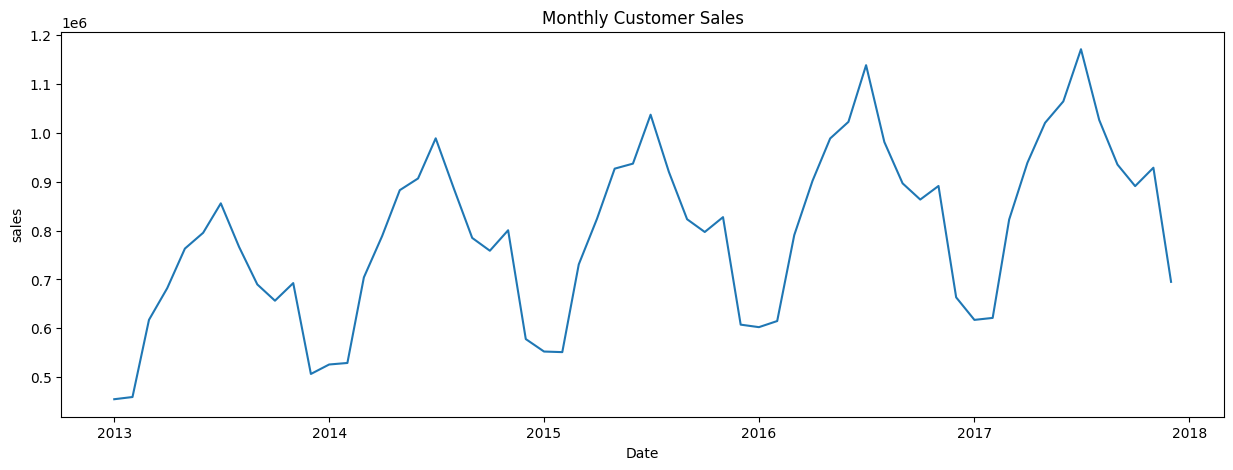

In [114]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales['date'],monthly_sales['sales'])
plt.xlabel('Date')
plt.ylabel('sales')
plt.title("Monthly Customer Sales")
plt.show()

In [115]:
monthly_sales['sales_diff']=monthly_sales['sales'].diff()
monthly_sales=monthly_sales.dropna()
monthly_sales.head(10)

,date,sales,sales_diff
1,2013-02-01,459417,4513.0
2,2013-03-01,617382,157965.0
3,2013-04-01,682274,64892.0
4,2013-05-01,763242,80968.0
5,2013-06-01,795597,32355.0
6,2013-07-01,855922,60325.0
7,2013-08-01,766761,-89161.0
8,2013-09-01,689907,-76854.0
9,2013-10-01,656587,-33320.0
10,2013-11-01,692643,36056.0


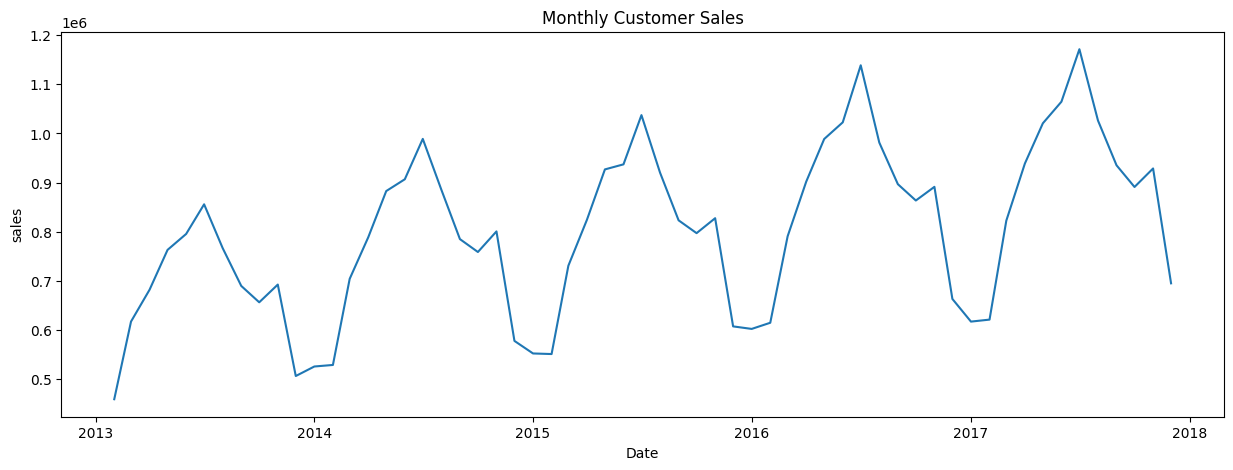

In [116]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales['date'],monthly_sales['sales'])
plt.xlabel('Date')
plt.ylabel('sales')
plt.title("Monthly Customer Sales")
plt.show()

In [117]:
supervised_data=monthly_sales.drop(['date','sales'],axis=1)

In [118]:
for i in range(1,13):
    column_name="month"+str(i)
    supervised_data[column_name]=supervised_data['sales_diff'].shift(i)
supervised_data=supervised_data.dropna().reset_index(drop=True)
supervised_data.head(10)

,sales_diff,month1,month2,month3,month4,month5,month6,month7,month8,month9,month10,month11,month12
0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0,4513.0
1,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0
2,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0
3,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0
4,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0
5,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0
6,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0
7,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0
8,-26241.0,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0
9,41900.0,-26241.0,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0


In [119]:
train_data=supervised_data[:-12]
test_data=supervised_data[-12:]
print('train_data:',train_data.shape)
print('train_data:',test_data.shape)

train_data: (35, 13)
train_data: (12, 13)


In [120]:
scaler=MinMaxScaler(feature_range=(-1,1))
scaler.fit(train_data)
train_data=scaler.transform(train_data)
test_data=scaler.transform(test_data)

In [133]:
x_train,y_train=train_data[:,1:],train_data[:,0:1]
x_test,y_test=test_data[:,1:],test_data[:,0:1]
y_train=y_train.ravel()
y_test=y_test.ravel()
print("X_train:",x_train.shape)
print("X_test:",x_test.shape)
print("Y_train:",y_train.shape)
print("Y_test:",y_test.shape)

X_train: (35, 12)
X_test: (12, 12)
Y_train: (35,)
Y_test: (12,)
[[-1.02635392  0.24535439 -0.05787474 -0.31370458 -0.67437352  0.68397168
   0.27578914  0.53846345  0.65919343  0.98155922  0.16933959  0.0816042 ]
 [-0.12204966 -1.02635392  0.24535439 -0.05787474 -0.31370458 -0.67437352
   0.68397168  0.27578914  0.53846345  0.65919343  0.98155922  0.16933959]
 [ 0.12731349 -0.12204966 -1.02635392  0.24535439 -0.05787474 -0.31370458
  -0.67437352  0.68397168  0.27578914  0.53846345  0.65919343  0.98155922]
 [ 1.10768225  0.12731349 -0.12204966 -1.02635392  0.24535439 -0.05787474
  -0.31370458 -0.67437352  0.68397168  0.27578914  0.53846345  0.65919343]
 [ 0.68467253  1.10768225  0.12731349 -0.12204966 -1.02635392  0.24535439
  -0.05787474 -0.31370458 -0.67437352  0.68397168  0.27578914  0.53846345]
 [ 0.51382935  0.68467253  1.10768225  0.12731349 -0.12204966 -1.02635392
   0.24535439 -0.05787474 -0.31370458 -0.67437352  0.68397168  0.27578914]
 [ 0.32551464  0.51382935  0.68467253  1.1

In [122]:
sales_dates=monthly_sales['date'][-12:].reset_index(drop=True)
predicted_df=pd.DataFrame(sales_dates)

In [123]:
actual_sales=monthly_sales['sales'][-13:].to_list()
print("actual_sales:",actual_sales)

actual_sales: [663411, 617306, 621369, 822667, 938862, 1020686, 1064624, 1171393, 1026403, 935263, 891160, 928837, 695170]


In [124]:
linear_model=LinearRegression()
linear_model.fit(x_train,y_train)
lr_predict=lr_model.predict(x_test)

In [125]:
lr_predict=lr_predict.reshape(-1,1)
#set matrix-contain the input features of the test data,and also predict the output
lr_pre_test_set=np.concatenate([lr_predict,x_test],axis=1)
lr_pre_test_set=scaler.inverse_transform(lr_pre_test_set)

In [126]:
result=[]
for index in range(0,len(lr_pre_test_set)):
    result.append(lr_pre_test_set[index][0]+actual_sales[index])

lr_pre_series=pd.Series(result,name="LINEAR PREDICTION")
predicted_df=predicted_df.merge(lr_pre_series,left_index=True,right_index=True)

    

In [127]:
# print('predicted_df:',predicted_df)

In [128]:
lr_msg=np.sqrt(mean_squared_error(predicted_df["LINEAR PREDICTION"],monthly_sales['sales'][-12:]))
lr_mae=mean_absolute_error(predicted_df["LINEAR PREDICTION"],monthly_sales['sales'][-12:])
lr_r2=r2_score(predicted_df["LINEAR PREDICTION"],monthly_sales['sales'][-12:])
print("lr_msg:",lr_msg)
print("lr_mae:",lr_mae)
print("lr_r2:",lr_r2)

lr_msg: 16221.272385416896
lr_mae: 12433.184266490784
lr_r2: 0.9906152516380968


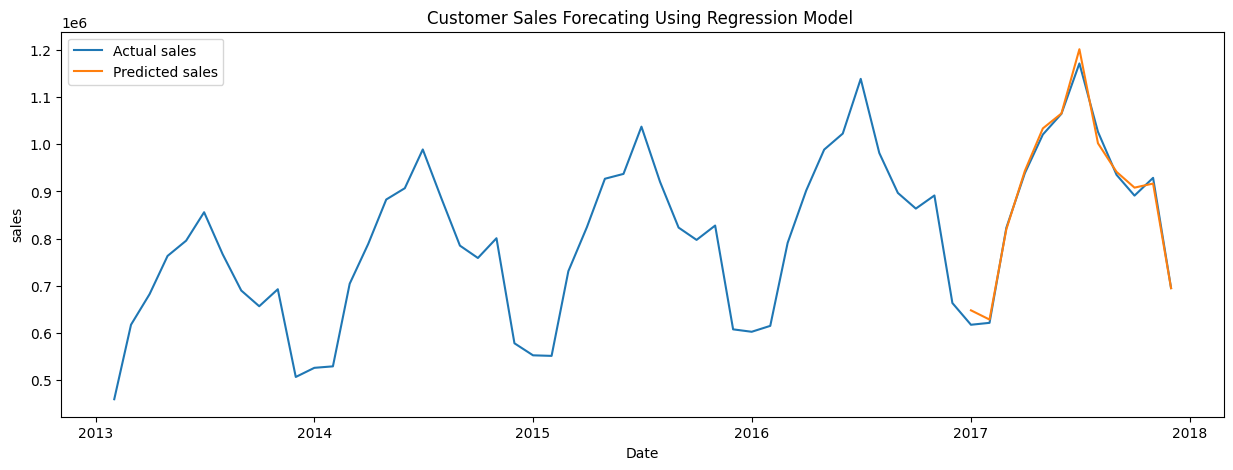

In [130]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales['date'],monthly_sales['sales'])
plt.plot(predicted_df['date'],predicted_df["LINEAR PREDICTION"])
plt.xlabel('Date')
plt.ylabel('sales')
plt.title("Customer Sales Forecating Using Regression Model ")
plt.legend(['Actual sales', 'Predicted sales'])
plt.show()